In [2]:
! pip install transformers datasets evaluate rouge_score py7zr accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 26.8 MB

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import random
import torch
from datasets import load_metric
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import Dataset, load_metric
from tqdm import tqdm
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
from datasets import load_dataset

sams_dataset = load_dataset("samsum", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [7]:
sams_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

### Converting the dictionary to dataframe for data exploration

In [8]:
train_data = pd.DataFrame(sams_dataset['train'])
test_data = pd.DataFrame(sams_dataset['test'])
val_data = pd.DataFrame(sams_dataset['validation'])

# 2. Exploratory Data Analysis

### (a). Conduct an initial exploration of the SAMSum dataset to gain insights into the characteristics of the dialogues and summaries.

In [9]:
train_data.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [10]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()
val_data_copy = val_data.copy()

#### Number of Turns in the dialogue: Provides an insight into the number of exchanges or turns in each dialogue

In [11]:
def number_turns(dialogue):
    dial_split = dialogue.split("\r\n")
    dialogue_dict = {}
    correct_dialogues = []

    current_speaker = None
    current_dialogue = []

    for line in dial_split:
        if ": " in line:
            speaker, text = line.split(": ", 1)
            if current_speaker is None:
                current_speaker = speaker
            if speaker == current_speaker:
                current_dialogue.append(text)
            else:
                correct_dialogues.append((current_speaker, "\r\n".join(current_dialogue)))
                current_speaker = speaker
                current_dialogue = [text]

    if current_speaker is not None and current_dialogue:
        correct_dialogues.append((current_speaker, "\r\n".join(current_dialogue)))

    for speaker, text in correct_dialogues:
        if speaker in dialogue_dict:
            dialogue_dict[speaker] += 1
        else:
            dialogue_dict[speaker] = 1

    return dialogue_dict, len(dialogue_dict)

In [12]:
results = train_data_copy['dialogue'].apply(number_turns)
train_data_copy['dialogue_speaker_counts'] = results.apply(lambda x: x[0])
train_data_copy['number_of_exchanges'] = results.apply(lambda x: x[1])

In [13]:
train_data_copy

,id,dialogue,summary,dialogue_speaker_counts,number_of_exchanges
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"{'Amanda': 2, 'Jerry': 1}",2
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,"{'Olivia': 2, 'Oliver': 2}",2
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,"{'Tim': 4, 'Kim': 3}",2
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,"{'Edward': 2, 'rachel': 2}",2
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","{'Sam': 6, 'Naomi': 6}",2
...,...,...,...,...,...
14727,13863028,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...,{'Romeo': 1},1
14728,13828570,Theresa: <file_photo>\r\nTheresa: <file_photo>...,Theresa is at work. She gets free food and fre...,"{'Theresa': 7, 'Louise': 6}",2
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...,"{'John': 5, 'Erica': 3, 'Faith': 5}",3
14730,13828395,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...,"{'Jennifer': 6, 'Celia': 6}",2


#### Number of words in Each dialogue

In [14]:
def number_of_words(dialogue):
    words = []
    for line in dialogue.split("\r\n"):
        words.extend(line.split())
    return len(words)
train_data_copy['num_of_words'] = train_data_copy['dialogue'].apply(number_of_words)

In [15]:
train_data_copy

,id,dialogue,summary,dialogue_speaker_counts,number_of_exchanges,num_of_words
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"{'Amanda': 2, 'Jerry': 1}",2,16
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,"{'Olivia': 2, 'Oliver': 2}",2,18
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,"{'Tim': 4, 'Kim': 3}",2,98
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,"{'Edward': 2, 'rachel': 2}",2,26
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","{'Sam': 6, 'Naomi': 6}",2,179
...,...,...,...,...,...,...
14727,13863028,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...,{'Romeo': 1},1,56
14728,13828570,Theresa: <file_photo>\r\nTheresa: <file_photo>...,Theresa is at work. She gets free food and fre...,"{'Theresa': 7, 'Louise': 6}",2,198
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...,"{'John': 5, 'Erica': 3, 'Faith': 5}",3,142
14730,13828395,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...,"{'Jennifer': 6, 'Celia': 6}",2,276


In [16]:
train_data_copy['num_of_words'].value_counts()

num_of_words
28     159
26     154
33     152
38     152
40     145
      ... 
553      1
362      1
449      1
612      1
441      1
Name: count, Length: 436, dtype: int64

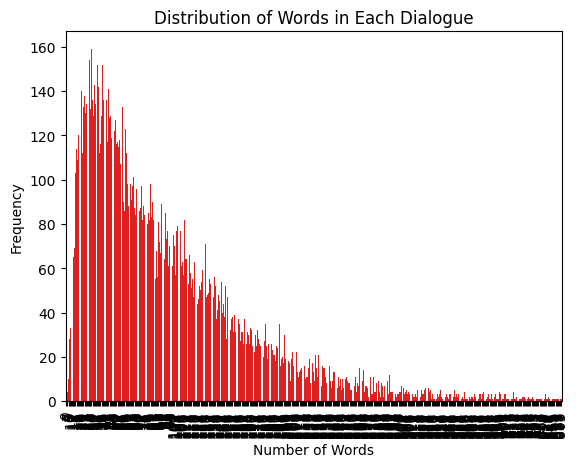

In [17]:
word_count_dialogue = train_data_copy['num_of_words'].value_counts().sort_index()
sns.barplot(x=word_count_dialogue.index, y=word_count_dialogue.values, color='red')
plt.title("Distribution of Words in Each Dialogue")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

#### Topics and Themes discussed in the Dialogues

In [18]:
def preprocess(text):
  # Replace line breaks with spaces
  text = text.replace("\r\n", " ")

  # Tokenize
  tokens = word_tokenize(text)

  # Convert to lower case
  tokens = [word.lower() for word in tokens]

  # Remove punctuation and non-alphabetic tokens
  tokens = [word for word in tokens if word.isalpha()]

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return tokens

In [19]:
train_data_copy['tokens'] = train_data_copy['dialogue'].apply(preprocess)

In [20]:
dictionary = corpora.Dictionary(train_data_copy['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in train_data_copy['tokens']]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

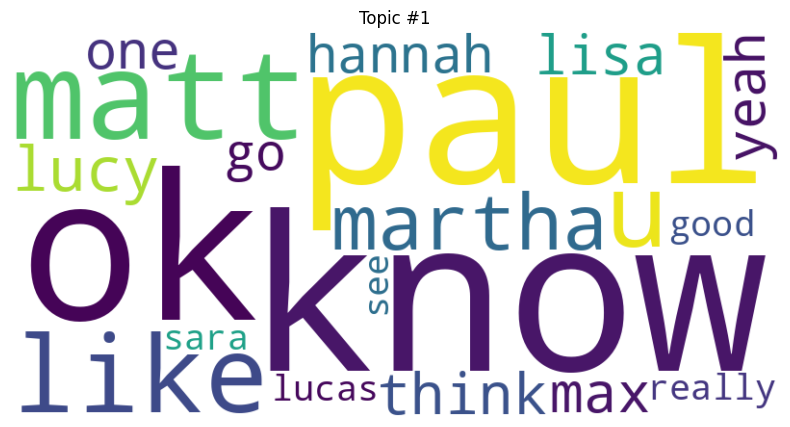

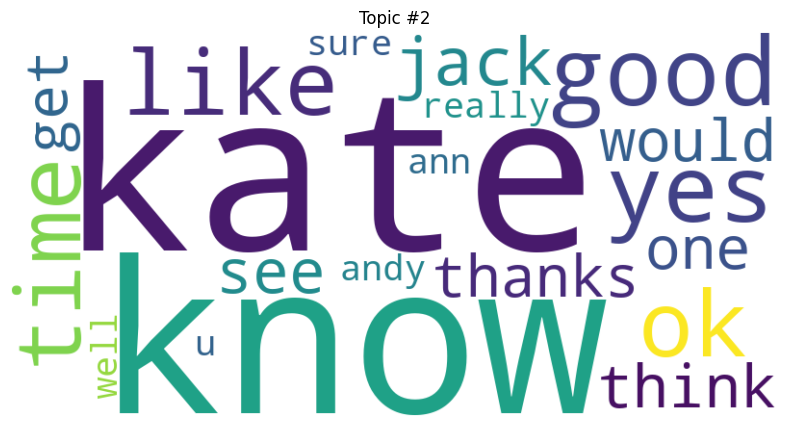

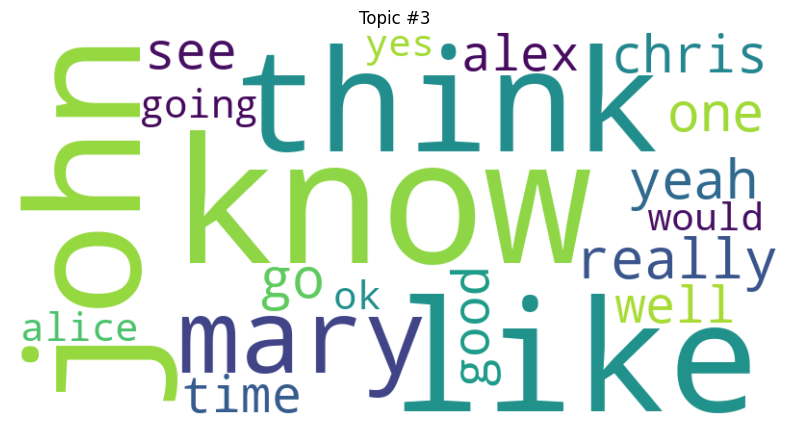

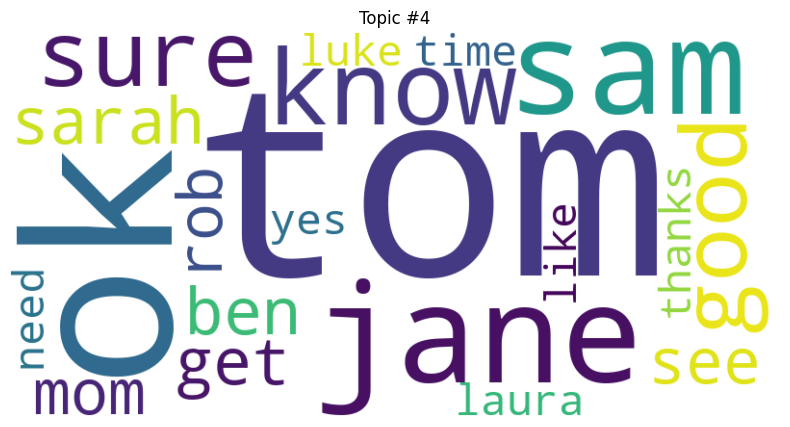

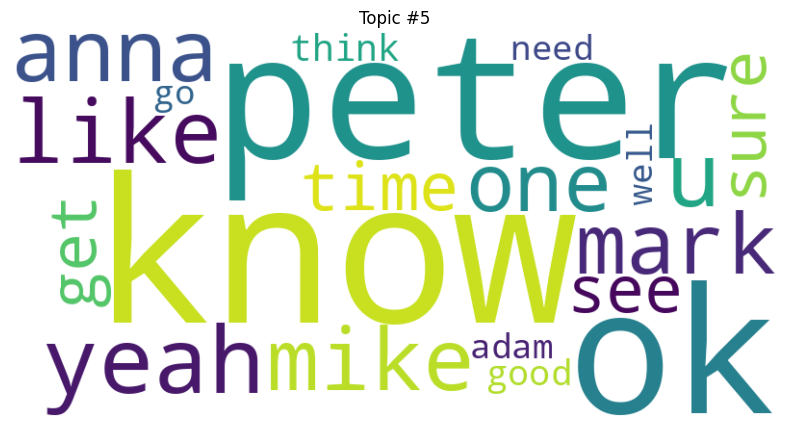

In [21]:
def generate_word_cloud(lda_model, topic_idx, num_words=20):
    # Get the topic's words and their probabilities
    topic = lda_model.show_topic(topic_idx, num_words)
    topic_words = {word: prob for word, prob in topic}

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic #{topic_idx + 1}')
    plt.show()

# Generate word clouds for each topic
for i in range(lda_model.num_topics):
    generate_word_cloud(lda_model, i)

#### Number of Words in the Summary

In [22]:
train_data_copy['num_of_words_summary'] = train_data_copy['summary'].apply(lambda x: len(x.split()))

In [23]:
train_data_copy

,id,dialogue,summary,dialogue_speaker_counts,number_of_exchanges,num_of_words,tokens,num_of_words_summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"{'Amanda': 2, 'Jerry': 1}",2,16,"[amanda, baked, cooky, want, jerry, sure, aman...",9
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,"{'Olivia': 2, 'Oliver': 2}",2,18,"[olivia, voting, election, oliver, liberal, al...",10
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,"{'Tim': 4, 'Kim': 3}",2,98,"[tim, hi, kim, bad, mood, tbh, going, lot, stu...",14
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,"{'Edward': 2, 'rachel': 2}",2,26,"[edward, rachel, think, ove, bella, rachel, do...",18
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","{'Sam': 6, 'Naomi': 6}",2,179,"[sam, hey, overheard, rick, say, something, sa...",27
...,...,...,...,...,...,...,...,...
14727,13863028,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...,{'Romeo': 1},1,56,"[romeo, people, may, know, list, greta, ah, ma...",16
14728,13828570,Theresa: <file_photo>\r\nTheresa: <file_photo>...,Theresa is at work. She gets free food and fre...,"{'Theresa': 7, 'Louise': 6}",2,198,"[theresa, theresa, theresa, hey, louise, u, th...",36
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...,"{'John': 5, 'Erica': 3, 'Faith': 5}",3,142,"[john, every, day, bad, news, japan, hunt, wha...",22
14730,13828395,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...,"{'Jennifer': 6, 'Celia': 6}",2,276,"[jennifer, dear, celia, jennifer, afternoon, c...",40


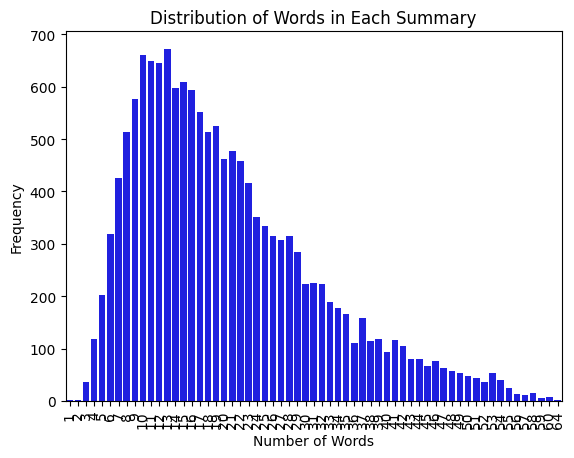

In [24]:
word_count_summary = train_data_copy['num_of_words_summary'].value_counts().sort_index()
sns.barplot(x=word_count_summary.index, y=word_count_summary.values, color='blue')
plt.title("Distribution of Words in Each Summary")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

#### Calculating the compression ratio between length of the dialogue to the length of the summary

In [25]:
train_data_copy['compression_ratio'] = train_data_copy['num_of_words']/train_data_copy['num_of_words_summary']

In [26]:
train_data_copy

,id,dialogue,summary,dialogue_speaker_counts,number_of_exchanges,num_of_words,tokens,num_of_words_summary,compression_ratio
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"{'Amanda': 2, 'Jerry': 1}",2,16,"[amanda, baked, cooky, want, jerry, sure, aman...",9,1.777778
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,"{'Olivia': 2, 'Oliver': 2}",2,18,"[olivia, voting, election, oliver, liberal, al...",10,1.800000
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,"{'Tim': 4, 'Kim': 3}",2,98,"[tim, hi, kim, bad, mood, tbh, going, lot, stu...",14,7.000000
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,"{'Edward': 2, 'rachel': 2}",2,26,"[edward, rachel, think, ove, bella, rachel, do...",18,1.444444
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","{'Sam': 6, 'Naomi': 6}",2,179,"[sam, hey, overheard, rick, say, something, sa...",27,6.629630
...,...,...,...,...,...,...,...,...,...
14727,13863028,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...,{'Romeo': 1},1,56,"[romeo, people, may, know, list, greta, ah, ma...",16,3.500000
14728,13828570,Theresa: <file_photo>\r\nTheresa: <file_photo>...,Theresa is at work. She gets free food and fre...,"{'Theresa': 7, 'Louise': 6}",2,198,"[theresa, theresa, theresa, hey, louise, u, th...",36,5.500000
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...,"{'John': 5, 'Erica': 3, 'Faith': 5}",3,142,"[john, every, day, bad, news, japan, hunt, wha...",22,6.454545
14730,13828395,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...,"{'Jennifer': 6, 'Celia': 6}",2,276,"[jennifer, dear, celia, jennifer, afternoon, c...",40,6.900000


### (b). Plot the length distribution of dialogues and summaries in the training set.

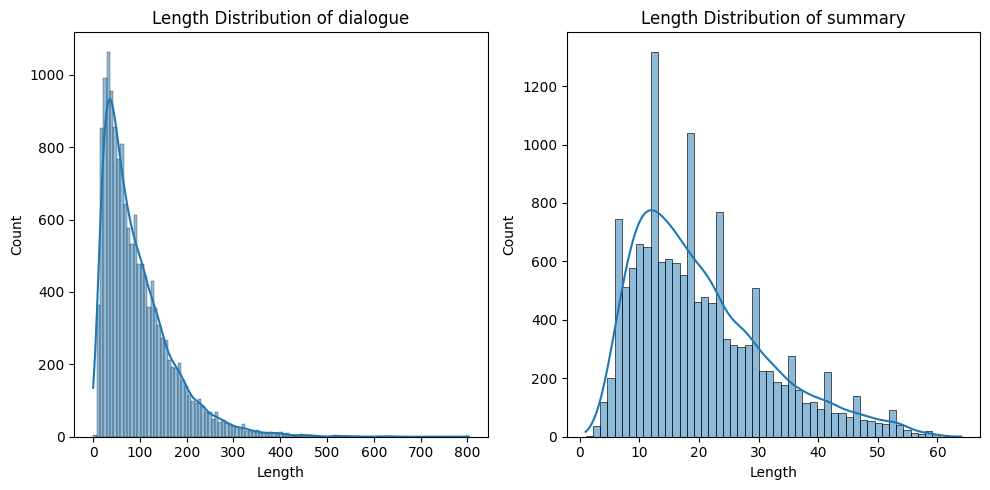

In [27]:
dialogue_len = [len(dialogue.split()) for dialogue in train_data_copy['dialogue']]
summary_len = [len(summary.split()) for summary in train_data_copy['summary']]
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(dialogue_len, ax=axes[0], kde=True)
axes[0].set_title('Length Distribution of dialogue')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')
sns.histplot(summary_len, ax=axes[1], kde=True)
axes[1].set_title('Length Distribution of summary')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

### (c). Display the 20 most common words in the dialogues and their frequencies.


#### 20 Most Common words in the dialogues and their frequencies in the training set

In [28]:
dialogue = " ".join(train_data_copy['dialogue'])
dialogue_words = dialogue.split()
dialogue_words_count = Counter(dialogue_words)
most_common_dialogue_words = dialogue_words_count.most_common(20)
most_common_dialogue_words

[('I', 37592),
 ('you', 31617),
 ('the', 29897),
 ('to', 28658),
 ('a', 21640),
 ('and', 15311),
 ('it', 14302),
 ('for', 11546),
 ('in', 10723),
 ('of', 10267),
 ('is', 10018),
 ('have', 9612),
 ('be', 8880),
 ('that', 8620),
 ('me', 7769),
 ('but', 7754),
 ('so', 7598),
 ('my', 7348),
 ('are', 7128),
 ("I'm", 7066)]

#### 20 Most Common words in the dialogues and their frequencies in the test set

In [29]:
dialogue = " ".join(test_data_copy['dialogue'])
dialogue_words = dialogue.split()
dialogue_words_count = Counter(dialogue_words)
most_common_dialogue_words = dialogue_words_count.most_common(20)
most_common_dialogue_words

[('I', 2135),
 ('you', 1715),
 ('the', 1680),
 ('to', 1552),
 ('a', 1230),
 ('and', 900),
 ('it', 756),
 ('for', 638),
 ('in', 590),
 ('is', 577),
 ('of', 572),
 ('have', 548),
 ('be', 492),
 ('that', 483),
 ('me', 444),
 ('my', 442),
 ('are', 418),
 ('but', 408),
 ('so', 405),
 ("I'm", 393)]

#### 20 Most Common words in the dialogues and their frequencies in the validation set

In [30]:
dialogue = " ".join(val_data_copy['dialogue'])
dialogue_words = dialogue.split()
dialogue_words_count = Counter(dialogue_words)
most_common_dialogue_words = dialogue_words_count.most_common(20)
most_common_dialogue_words

[('I', 2008),
 ('you', 1672),
 ('the', 1619),
 ('to', 1489),
 ('a', 1157),
 ('and', 807),
 ('it', 763),
 ('for', 658),
 ('in', 602),
 ('is', 560),
 ('have', 532),
 ('of', 525),
 ('be', 514),
 ('that', 463),
 ('but', 431),
 ('me', 424),
 ("I'm", 405),
 ('so', 395),
 ('at', 385),
 ('my', 384)]

# 3. Inference with Pre-Trained Models

### (a). Choose at least three pre-trained summarization models from the Hugging Face model hub, such as facebook/bart-large-cnn or t5-large.

#### BART-LARGE-CNN

In [31]:
from transformers import pipeline
summarizer_bart = pipeline("summarization", model="facebook/bart-large-cnn")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


#### T5-Large

In [32]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
# Load T5 tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained('t5-large')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-large')

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

#### Pegasus-Xsum

In [33]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
# Load Pegasus tokenizer and model
pegasus_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
pegasus_model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

### (b) Use the models to generate summaries for a few randomly selected dialogues. Analyze the quality of these summaries: Are they coherent? Do they capture the essential points in the conversation?



In [34]:
# Sample Text
n = 5
sampled_data = train_data.sample(n=5)
sample_dialogues = sampled_data['dialogue'].tolist()
sample_summaries = sampled_data['summary'].tolist()

#### BART-LARGE-CNN Summarizer

In [35]:
bart_results = []
for text in sample_dialogues:
  bart_results.append(summarizer_bart(text, max_length=50, min_length=30, do_sample=False))

Your max_length is set to 50, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


In [36]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
for diag, orig, result in zip(sample_dialogues, sample_summaries, bart_results):
  print(f"Original Conversation: {diag}")
  print("-"*150)
  scores = scorer.score(orig, result[0]['summary_text'])
  print(f"Original Summary: {orig}")
  print(f"Summary from BART: {result[0]['summary_text']}")
  print(f"ROUGE Scores: {scores}")
  print("*"*150)

Original Conversation: Ralph: Have you ever heard of a company called "Venque"?
Victoria: No. what is this?
Ralph: <file_other>
Ralph: Check it out
Charles: it's a Canadian company
Charles: They have very beautiful but expensive products. 
Ralph: What do think about this bag?
Ralph: <file_other>
Charles: Very stylish 
------------------------------------------------------------------------------------------------------------------------------------------------------
Original Summary: The Canadian company Venque has beautiful but expensive products. 
Summary from BART: Charles: They have very beautiful but expensive products. Ralph: Have you ever heard of a company called "Venque"? Victoria: No. what is this? Charles: It's a Canadian company called Venque.
ROUGE Scores: {'rouge1': Score(precision=0.22580645161290322, recall=0.7777777777777778, fmeasure=0.35000000000000003), 'rouge2': Score(precision=0.13333333333333333, recall=0.5, fmeasure=0.2105263157894737), 'rougeL': Score(precision

In [37]:
rouge = load_metric("rouge", trust_remote_code=True)

generated_summaries = bart_results
reference_summaries = sample_summaries

rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print(rouge_scores)

<ipython-input-37-dcc77d28572e>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge", trust_remote_code=True)


{'rouge1': AggregateScore(low=Score(precision=0.2316205533596838, recall=0.36918518518518517, fmeasure=0.30422372227579564), mid=Score(precision=0.28501848782353695, recall=0.5012390572390573, fmeasure=0.3477467052394728), high=Score(precision=0.33740323997336624, recall=0.6797575757575757, fmeasure=0.38693989071038243)), 'rouge2': AggregateScore(low=Score(precision=0.03428571428571429, recall=0.05, fmeasure=0.04067796610169492), mid=Score(precision=0.07469696969696969, recall=0.17629310344827587, fmeasure=0.09889830508474577), high=Score(precision=0.10547619047619047, recall=0.33999999999999997, fmeasure=0.15389830508474578)), 'rougeL': AggregateScore(low=Score(precision=0.14044795783926217, recall=0.22992592592592592, fmeasure=0.17055425448868072), mid=Score(precision=0.18802045702466458, recall=0.32676094276094275, fmeasure=0.22850346696055474), high=Score(precision=0.23465092722455974, recall=0.4235959595959596, fmeasure=0.2750241080038573)), 'rougeLsum': AggregateScore(low=Score(p

#### T5-Large Summarizer

In [38]:
t5_results = []
for text in sample_dialogues:
  # Tokenize input
  input_ids = t5_tokenizer.encode(text, return_tensors='pt')

  # Generate summary
  summary_ids = t5_model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)

  # Decode and print summary
  summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

  t5_results.append(summary)

In [39]:
t5_results

['Ralph: What do you think about this bag? Ralph: What do you think about this bag? Ralph: What do you think about this bag? Ralph: What do you think about this bag? Ralph: What do you think about this? Charles: Very stylish Charles: Very stylish Charles: Very stylish Charles: Very stylish Charles: Very stylish Charles:',
 "Elizabeth: ok, i'll pick you up at 9 Elizabeth: ok, i'll pick you up at 9 Elizabeth: ok, i'll pick you up at 9 Elizabeth: ok, i'll pick you up at 9 Elizabeth: ok, i'll pick you up at 9 Elizabeth: ok, i'll pick you up at 9 then!",
 "? Paul: Yes Mike: Yes Mike: I'll try :). Mike: Yes Mike: I'll try Mike: I'll try Mike: I'll try Mike: I'll try.. Mike: Yes Mike: Yes Mike: Yes Mike: Yes Mike: Yes Mike: Yes Mike: Yes yes yes yes yes Mike: Yes Yes yes yes yes yes yes Yes Yes Mike: Yes Yes yes yes",
 "Jim: I'll see you all soon Lane: Jim: thanks Jim: I Jim: thanks Jim: I'll do Jim: Jim: thanks Jim: I'll do Jim: I'll do Jim: I'll do Jim: I'll do Jim: I'll do Jim: I will do J

In [40]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
for diag, orig, result in zip(sample_dialogues, sample_summaries, t5_results):
  print(f"Original Conversation: {diag}")
  print("-"*150)
  scores = scorer.score(orig, result)
  print(f"Original Summary: {orig}")
  print(f"Summary from BART: {result}")
  print(f"ROUGE Scores: {scores}")
  print("*"*150)

Original Conversation: Ralph: Have you ever heard of a company called "Venque"?
Victoria: No. what is this?
Ralph: <file_other>
Ralph: Check it out
Charles: it's a Canadian company
Charles: They have very beautiful but expensive products. 
Ralph: What do think about this bag?
Ralph: <file_other>
Charles: Very stylish 
------------------------------------------------------------------------------------------------------------------------------------------------------
Original Summary: The Canadian company Venque has beautiful but expensive products. 
Summary from BART: Ralph: What do you think about this bag? Ralph: What do you think about this bag? Ralph: What do you think about this bag? Ralph: What do you think about this bag? Ralph: What do you think about this? Charles: Very stylish Charles: Very stylish Charles: Very stylish Charles: Very stylish Charles: Very stylish Charles:
ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, r

In [41]:
rouge = load_metric("rouge")

generated_summaries = t5_results
reference_summaries = sample_summaries

rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print(rouge_scores)

{'rouge1': AggregateScore(low=Score(precision=0.025454545454545452, recall=0.07272727272727272, fmeasure=0.03636363636363636), mid=Score(precision=0.08093261916990731, recall=0.1816969696969697, fmeasure=0.1093048128342246), high=Score(precision=0.1356075036075036, recall=0.2684727272727272, fmeasure=0.17757066462948817)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.007407407407407407, recall=0.013793103448275862, fmeasure=0.009638554216867469), high=Score(precision=0.02222222222222222, recall=0.041379310344827586, fmeasure=0.028915662650602407)), 'rougeL': AggregateScore(low=Score(precision=0.01967715899919291, recall=0.06036363636363636, fmeasure=0.03069155844155852), mid=Score(precision=0.06636818548682956, recall=0.14133333333333334, fmeasure=0.08865546218487395), high=Score(precision=0.11541590725658521, recall=0.221037037037037, fmeasure=0.1511957601222307)), 'rougeLsum': AggregateScore(low=Score(precision=0.01630347054075867

#### Pegasus-Xsum Summarizer

In [42]:
pegasus_results = []
for text in sample_dialogues:
  # Tokenize input
  input_ids = pegasus_tokenizer.encode(text, return_tensors='pt')

  # Generate summary
  summary_ids = pegasus_model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)

  # Decode and print summary
  summary = pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

  pegasus_results.append(summary)

In [43]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
for diag, orig, result in zip(sample_dialogues, sample_summaries, pegasus_results):
  print(f"Original Conversation: {diag}")
  print("-"*150)
  scores = scorer.score(orig, result)
  print(f"Original Summary: {orig}")
  print(f"Summary from BART: {result}")
  print(f"ROUGE Scores: {scores}")
  print("*"*150)

Original Conversation: Ralph: Have you ever heard of a company called "Venque"?
Victoria: No. what is this?
Ralph: <file_other>
Ralph: Check it out
Charles: it's a Canadian company
Charles: They have very beautiful but expensive products. 
Ralph: What do think about this bag?
Ralph: <file_other>
Charles: Very stylish 
------------------------------------------------------------------------------------------------------------------------------------------------------
Original Summary: The Canadian company Venque has beautiful but expensive products. 
Summary from BART: Ralph and Victoria are joined by Charles to discuss a new handbag.
ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
******************************************************************************************************************************************************
Original Conversat

In [44]:
rouge = load_metric("rouge")

generated_summaries = pegasus_results
reference_summaries = sample_summaries

rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print(rouge_scores)

{'rouge1': AggregateScore(low=Score(precision=0.1, recall=0.05703703703703704, fmeasure=0.0731457800511509), mid=Score(precision=0.2638888888888889, recall=0.16176430976430978, fmeasure=0.1958178448284788), high=Score(precision=0.4288888888888889, recall=0.28218181818181814, fmeasure=0.3295546558704453)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.06547619047619048, recall=0.047692307692307694, fmeasure=0.05505882352941176), high=Score(precision=0.17976190476190473, recall=0.1276923076923077, fmeasure=0.1491764705882353)), 'rougeL': AggregateScore(low=Score(precision=0.06944444444444445, recall=0.0399555555555556, fmeasure=0.04660633484162896), mid=Score(precision=0.19344444444444445, recall=0.12428282828282829, fmeasure=0.14820816550524454), high=Score(precision=0.35, recall=0.2537373737373737, fmeasure=0.29355229505990044)), 'rougeLsum': AggregateScore(low=Score(precision=0.07193611111111116, recall=0.0399555555555556, fmeasure=

# 4. Fine-Tuning

#### (a) Choose one of the pre-trained summarization models from the previous part.
#### (b) Preprocess the dataset to fit it to the input format required by the chosen model, which may include tokenizing the dialogues and their summaries.


In [45]:
# Loading the tokenizer
model_checkpoints = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

In [46]:
def preprocess(batch, tokenizer):
  # Tokenize the Dialogue
  model_inputs = tokenizer(batch['dialogue'], max_length=512, padding='max_length', truncation=True)

  # Tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(batch['summary'], max_length=128, padding='max_length', truncation=True)

  # Set labels
  model_inputs['labels'] = targets['input_ids']

  return model_inputs

In [47]:
train_data_batched = Dataset.from_pandas(train_data)
tokenized_data_train = train_data_batched.map(lambda batch: preprocess(batch, tokenizer), batched=True)
tokenized_data_train = tokenized_data_train.remove_columns(['dialogue', 'summary'])

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [48]:
train_data_batched = Dataset.from_pandas(val_data)
tokenized_data_val = train_data_batched.map(lambda batch: preprocess(batch, tokenizer), batched=True)
tokenized_data_val = tokenized_data_val.remove_columns(['dialogue', 'summary'])

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

#### (c) Train the model on the SAMSum corpus, monitoring its performance on the vali- dation set, and adjust the hyperparameters as needed.
#### (d) Employ appropriate metrics for evaluating summarization quality, such as ROUGE scores, which compare the generated summaries against the reference summaries.


In [49]:
# Load the model
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large-cnn')
collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [50]:
rouge_metric = load_metric("rouge")
def compute_rouge(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predictions and references
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the ROUGE scores
    result = rouge_metric.compute(predictions=pred_str, references=label_str, use_stemmer=True)

    # Extract the ROUGE-L score
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return result

In [55]:
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/PA3',
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_val,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)

In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.293500,0.299304,41.560388,21.600904,32.175859,32.191424


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=3683, training_loss=0.2882445751568755, metrics={'train_runtime': 4963.0904, 'train_samples_per_second': 2.968, 'train_steps_per_second': 0.742, 'total_flos': 1.5962892499156992e+16, 'train_loss': 0.2882445751568755, 'epoch': 1.0})

In [57]:
val_metrics = trainer.predict(tokenized_data_val)
val_metrics.metrics

{'test_loss': 0.29930368065834045,
 'test_rouge1': 41.5603884672576,
 'test_rouge2': 21.600903612879975,
 'test_rougeL': 32.17585904379811,
 'test_rougeLsum': 32.1914240892875,
 'test_runtime': 651.5128,
 'test_samples_per_second': 1.256,
 'test_steps_per_second': 0.628}

# 5. Evaluation and Analysis

In [59]:
len(test_data)

819

#### (a) Evaluate the fine-tuned model’s performance on the test set. Compare these results to the model’s pre-fine-tuning performance using the same dialogues to assess the impact of fine-tuning.

In [62]:
import torch
batch_size = 8
test_sampled = test_data.reset_index(drop=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)

rouge_metric = load_metric("rouge")

for i in tqdm(range(0, len(test_sampled), batch_size)):
  batch = test_sampled.iloc[i:i+batch_size]
  dialogues = batch['dialogue'].tolist()
  summaries = batch['summary'].tolist()
  outputs = summarizer(dialogues)
  generated_summaries = [output['summary_text'] for output in outputs]
  rouge_metric.add_batch(predictions=generated_summaries, references=summaries)

rouge_metric.compute()

print(rouge_scores)

  0%|          | 0/103 [00:00<?, ?it/s]Your max_length is set to 142, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)
Your max_length is set to 142, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
  1%|          | 1/103 [00:07<12:50,  7.55s/it]Your max_length is set to 142, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_length is set to 142, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you

{'rouge1': AggregateScore(low=Score(precision=0.1, recall=0.05703703703703704, fmeasure=0.0731457800511509), mid=Score(precision=0.2638888888888889, recall=0.16176430976430978, fmeasure=0.1958178448284788), high=Score(precision=0.4288888888888889, recall=0.28218181818181814, fmeasure=0.3295546558704453)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.06547619047619048, recall=0.047692307692307694, fmeasure=0.05505882352941176), high=Score(precision=0.17976190476190473, recall=0.1276923076923077, fmeasure=0.1491764705882353)), 'rougeL': AggregateScore(low=Score(precision=0.06944444444444445, recall=0.0399555555555556, fmeasure=0.04660633484162896), mid=Score(precision=0.19344444444444445, recall=0.12428282828282829, fmeasure=0.14820816550524454), high=Score(precision=0.35, recall=0.2537373737373737, fmeasure=0.29355229505990044)), 'rougeLsum': AggregateScore(low=Score(precision=0.07193611111111116, recall=0.0399555555555556, fmeasure=

#### (b) Analyze the generated summaries for improvements in capturing key points, co- herence, and fluency. Discuss the fine-tuning’s impact on the model’s ability to summarize dialogues.

In [63]:
bart_results_finetuned = []
for text in sample_dialogues:
  bart_results_finetuned.append(summarizer_bart(text, max_length=50, min_length=30, do_sample=False))

Your max_length is set to 50, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


In [64]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
for diag, orig, result in zip(sample_dialogues, sample_summaries, bart_results_finetuned):
  print(f"Original Conversation: {diag}")
  print("-"*150)
  scores = scorer.score(orig, result[0]['summary_text'])
  print(f"Original Summary: {orig}")
  print(f"Summary from BART: {result[0]['summary_text']}")
  print(f"ROUGE Scores: {scores}")
  print("*"*150)

Original Conversation: Ralph: Have you ever heard of a company called "Venque"?
Victoria: No. what is this?
Ralph: <file_other>
Ralph: Check it out
Charles: it's a Canadian company
Charles: They have very beautiful but expensive products. 
Ralph: What do think about this bag?
Ralph: <file_other>
Charles: Very stylish 
------------------------------------------------------------------------------------------------------------------------------------------------------
Original Summary: The Canadian company Venque has beautiful but expensive products. 
Summary from BART: Charles: They have very beautiful but expensive products. Ralph: Have you ever heard of a company called "Venque"? Victoria: No. what is this? Charles: It's a Canadian company called Venque.
ROUGE Scores: {'rouge1': Score(precision=0.22580645161290322, recall=0.7777777777777778, fmeasure=0.35000000000000003), 'rouge2': Score(precision=0.13333333333333333, recall=0.5, fmeasure=0.2105263157894737), 'rougeL': Score(precision